# Notebook to check integral:

This notebook describes how I get from ERF for CO2 to $\Delta T$ for CO2 using this equation:

\begin{align*}
\Delta T_x (t) &= \int_0^t ERF_x(t') IRF(t-t') dt' \\
\end{align*}

#### The Impulse response function (IRF):
In these calculations we use:
\begin{align*}
IRF(t) = \frac{q_1}{d_1} \exp\Big(\frac{-t}{d_1}\Big) + \frac{q_2}{d_2} \exp\Big(\frac{-t}{d_2}\Big)
\end{align*}

Where the constants, $q_i$ and $d_i$ are shown below. 



In [1]:
import pandas as pd
import xarray as xr
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate

from openscm_units import unit_registry  # pip install openscm-units
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel, constants  # pip install openscm-twolayermodel
from scmdata import ScmRun  # pip install scmdata

%load_ext autoreload
%autoreload 2
# from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR

/Users/znicholls/Documents/AGCEC/MCastle/openscm-twolayermodel/src/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


### Get IRF parameters 

In [2]:
# fn_IRF_constants = INPUT_DATA_DIR /'recommended_irf_from_2xCO2_2021_02_25_222758.csv'
fn_IRF_constants = 'recommended_irf_from_2xCO2_2021_02_25_222758.csv'

irf_consts = pd.read_csv(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'
irf_consts  # [d1]

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.649789,147.168593,1.31,1.027856,0.880636,3.424102,285.003478,0.443768,0.319591,1.027856,3.0,1.801052,3.93


In [3]:
# lets get the irf values from 0 until i
d1 = float(irf_consts[ld1])
d2 = float(irf_consts[ld2])
q1 = float(irf_consts[lq1])
q2 = float(irf_consts[lq2])

print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=3.4241020923110033, d2=285.0034778419114, q1=0.4437677288834471, q2=0.31959104974250885


### Path input data ERF

In [4]:
# from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR / 'ERF_data.nc'
# PATH_DATASET = OUTPUT_DATA_DIR/'historic_delta_GSAT/hist_ERF_est.csv'
PATH_DATASET = "test_erf.csv"

### Open ERF dataset:

In [5]:
df = pd.read_csv(PATH_DATASET, index_col=0)
da_ERF = df.to_xarray().to_array()#'variable'
# da_ERF = da_ERF.rename({'index':'year'})
#ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
ds = xr.Dataset({'ERF':da_ERF})
ds
#da_ERF = ds['ERF']

<xarray.Dataset>
Dimensions:   (variable: 19, year: 270)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
  * variable  (variable) <U30 'co2' 'ch4' 'n2o' ... 'total_natural' 'total'
Data variables:
    ERF       (variable, year) float64 0.0 0.001416 0.002832 ... 2.783 2.838

In [6]:
# name of output variable
name_deltaT = 'Delta T'

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'
percentile = 'percentile'

In [7]:
ds['ERF'].to_pandas().transpose().to_csv('ERF_timeseries.csv')

### Simple pre-processing

In [8]:
ds['time'] = pd.to_datetime(ds['year'].to_pandas().index.map(str), format='%Y')

# delta_t is 1 (year)
ds['delta_t'] = xr.DataArray(np.ones(len(ds['year'])), dims='year', coords={'year': ds['year']})
ds

<xarray.Dataset>
Dimensions:   (variable: 19, year: 270)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
  * variable  (variable) <U30 'co2' 'ch4' 'n2o' ... 'total_natural' 'total'
Data variables:
    ERF       (variable, year) float64 0.0 0.001416 0.002832 ... 2.783 2.838
    time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

# Integrate from ERF to delta T



## IRF function: 

In [9]:
def IRF(t, d1, q1, d2, q2):
    """
    Returns the IRF function for:
    :param q2:
    :param d2:
    :param q1:
    :param d1:
    :param t: Time in years
    :return:
    IRF
    """
    #print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')
    irf = q1 / d1 * np.exp(-t / d1) + q2 / d2 * np.exp(-t / d2)
    return irf
    # l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))



Calculate for 2019, meaning integrating over i years:

In [10]:
i = 2019-1750
i

269

## select only CO2 for check:

In [11]:
ds_in = ds.copy().sel(variable='co2')
ds_in

<xarray.Dataset>
Dimensions:   (year: 270)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
    variable  <U30 'co2'
Data variables:
    ERF       (year) float64 0.0 0.001416 0.002832 ... 2.089 2.122 2.156
    time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

### slice data to contain only years before year i

In [12]:
erf ='ERF'
ds_short = ds_in[{'year': slice(0, i + 1)}].copy()
ds_short

<xarray.Dataset>
Dimensions:   (year: 270)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
    variable  <U30 'co2'
Data variables:
    ERF       (year) float64 0.0 0.001416 0.002832 ... 2.089 2.122 2.156
    time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

In [13]:
# lets get the current year
current_year = ds_short['year'][{'year': i}]  # .dt.year
current_year

<xarray.DataArray 'year' ()>
array(2019)
Coordinates:
    year      int64 2019
    variable  <U30 'co2'

### IRF is calculated for t-t': calculates t-t'

In [14]:
# lets get a list of years
_years = ds_short['year']  # .dt.year
# lets get the year delta until current year(i)
ds_short['end_year_delta'] = current_year - _years
print(ds_short)

<xarray.Dataset>
Dimensions:         (year: 270)
Coordinates:
  * year            (year) int64 1750 1751 1752 1753 ... 2016 2017 2018 2019
    variable        <U30 'co2'
Data variables:
    ERF             (year) float64 0.0 0.001416 0.002832 ... 2.089 2.122 2.156
    time            (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t         (year) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    end_year_delta  (year) int64 269 268 267 266 265 264 263 ... 6 5 4 3 2 1 0


### Calculate IRF:

In [15]:
ds_short['irf'] = IRF(
    # t-t':
    ds_short['end_year_delta'] * ds_short['delta_t'], 
    # parameters
    d1, q1, d2, q2)
ds_short['irf']

<xarray.DataArray 'irf' (year: 270)>
array([0.00043635, 0.00043789, 0.00043942, 0.00044097, 0.00044252,
       0.00044407, 0.00044564, 0.0004472 , 0.00044877, 0.00045035,
       0.00045193, 0.00045352, 0.00045512, 0.00045672, 0.00045832,
       0.00045993, 0.00046155, 0.00046317, 0.0004648 , 0.00046643,
       0.00046807, 0.00046972, 0.00047137, 0.00047303, 0.00047469,
       0.00047636, 0.00047803, 0.00047971, 0.0004814 , 0.00048309,
       0.00048479, 0.00048649, 0.0004882 , 0.00048992, 0.00049164,
       0.00049337, 0.0004951 , 0.00049684, 0.00049859, 0.00050034,
       0.0005021 , 0.00050386, 0.00050563, 0.00050741, 0.0005092 ,
       0.00051099, 0.00051278, 0.00051458, 0.00051639, 0.00051821,
       0.00052003, 0.00052186, 0.00052369, 0.00052553, 0.00052738,
       0.00052923, 0.00053109, 0.00053296, 0.00053483, 0.00053671,
       0.0005386 , 0.00054049, 0.00054239, 0.0005443 , 0.00054621,
       0.00054813, 0.00055006, 0.00055199, 0.00055393, 0.00055588,
       0.00055783, 0.00055979, 0.00056176, 0.00056374, 0.00056572,
       0.00056771, 0.0005697 , 0.0005717 , 0.00057371, 0.00057573,
       0.00057775, 0.00057978, 0.00058182, 0.00058387, 0.00058592,
       0.00058798, 0.00059004, 0.00059212, 0.0005942 , 0.00059629,
       0.00059838, 0.00060049, 0.0006026 , 0.00060472, 0.00060684,
       0.00060898, 0.00061112, 0.00061326, 0.00061542, 0.00061758,
...
       0.00079229, 0.00079508, 0.00079787, 0.00080068, 0.00080349,
       0.00080632, 0.00080915, 0.00081199, 0.00081485, 0.00081771,
       0.00082059, 0.00082347, 0.00082637, 0.00082927, 0.00083218,
       0.00083511, 0.00083804, 0.00084099, 0.00084395, 0.00084691,
       0.00084989, 0.00085288, 0.00085587, 0.00085888, 0.0008619 ,
       0.00086493, 0.00086797, 0.00087102, 0.00087408, 0.00087716,
       0.00088024, 0.00088333, 0.00088644, 0.00088955, 0.00089268,
       0.00089582, 0.00089897, 0.00090213, 0.0009053 , 0.00090848,
       0.00091168, 0.00091488, 0.0009181 , 0.00092133, 0.00092457,
       0.00092783, 0.00093109, 0.00093437, 0.00093767, 0.00094098,
       0.00094431, 0.00094765, 0.00095102, 0.00095441, 0.00095783,
       0.00096128, 0.00096477, 0.00096832, 0.00097193, 0.00097562,
       0.00097941, 0.00098335, 0.00098746, 0.00099182, 0.00099648,
       0.00100157, 0.00100721, 0.00101359, 0.00102095, 0.00102963,
       0.00104006, 0.00105284, 0.00106876, 0.00108889, 0.00111463,
       0.0011479 , 0.00119124, 0.00124807, 0.00132295, 0.001422  ,
       0.00155341, 0.00172817, 0.00196095, 0.00227145, 0.00268601,
       0.00323993, 0.00398047, 0.0049709 , 0.006296  , 0.00806926,
       0.01044267, 0.01361978, 0.01787319, 0.02356792, 0.03119283,
       0.04140255, 0.05507377, 0.07338049, 0.09789494, 0.13072256])
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
    variable  <U30 'co2'

# The integrand:


\begin{align*}
 ERF_x(t') IRF(t-t') \cdot \Delta t' 
\end{align*}

In [16]:
# lets do the famous integral
ds_short['to_integrate'] = \
        ds_short[erf] * \
        ds_short['irf'] * \
        ds_short['delta_t']

In [17]:
ds_short

<xarray.Dataset>
Dimensions:         (year: 270)
Coordinates:
  * year            (year) int64 1750 1751 1752 1753 ... 2016 2017 2018 2019
    variable        <U30 'co2'
Data variables:
    ERF             (year) float64 0.0 0.001416 0.002832 ... 2.089 2.122 2.156
    time            (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t         (year) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    end_year_delta  (year) int64 269 268 267 266 265 264 263 ... 6 5 4 3 2 1 0
    irf             (year) float64 0.0004364 0.0004379 ... 0.09789 0.1307
    to_integrate    (year) float64 0.0 6.201e-07 1.244e-06 ... 0.2077 0.2819

### Finally do the sum:

In [18]:
ds_short['to_integrate'].sum()

<xarray.DataArray 'to_integrate' ()>
array(1.17324007)
Coordinates:
    variable  <U30 'co2'

## Do the sum without a Riemann approximation

In [19]:
def combo_integrand(t, d1, q1, d2, q2, erf, end_year):
    erf_interp = np.interp(t, erf["year"].values, erf.values)
#     print(erf_interp)
    delta_t = end_year - t
#     print(delta_t)
    irf = IRF(delta_t, d1, q1, d2, q2)
#     print(irf)
    integrand = erf_interp * irf
    
    return integrand

In [20]:
end_year = 2019
tmp = scipy.integrate.quad(combo_integrand, 1750, end_year, args=(d1, q1, d2, q2, ds_short[erf], end_year), limit=500)
exact_integration_result = tmp[0]
exact_integration_result

/Users/znicholls/Documents/AGCEC/MCastle/openscm-twolayermodel/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  


1.0251449586080135

In [21]:
# double check that it is just the difference because of the Riemann approximation,
# not sum silly coding error
riemann_approx = combo_integrand(np.arange(1750, 2019 + 1), d1, q1, d2, q2, ds_short[erf], end_year).sum()
np.testing.assert_allclose(riemann_approx, ds_short['to_integrate'].sum())
riemann_approx

1.1732400720611262

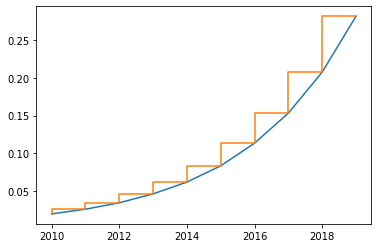

In [22]:
plt.plot(ds_short['to_integrate']['year'].values[-10:], ds_short['to_integrate'].values[-10:])
plt.step(ds_short['to_integrate']['year'].values[-10:], ds_short['to_integrate'].values[-10:])

## Compare with openscm-twolayermodel

In [23]:
recommend_paras = pd.read_csv("recommended_irf_from_2xCO2_2021_02_25_222758.csv").iloc[0, :]
erf = pd.read_csv("test_erf.csv", index_col=0)
scenario = "test"
unit = "W/m^2"

driver = ScmRun(
    data=erf["co2"].values,
    index=erf.index.values,
    columns={
        "unit": unit,
        "model": "custom",
        "scenario": scenario,
        "region": "World",
        "variable": "Effective Radiative Forcing",
    },
)
du = (
    recommend_paras["C (W yr / m^2 / K)"] 
    * unit_registry("W yr / m^2 / delta_degC")
    / constants.DENSITY_WATER
    / constants.HEAT_CAPACITY_WATER
).to("m")

dl = (
    recommend_paras["C_d (W yr / m^2 / K)"] 
    * unit_registry("W yr / m^2 / delta_degC")
    / constants.DENSITY_WATER
    / constants.HEAT_CAPACITY_WATER
).to("m")

two_layer = TwoLayerModel(
    # the naming is confusing because I follow Geoffroy, Ch. 7 Appendix does its own thing
    # the units should be clear
    lambda0=recommend_paras["alpha (W / m^2 / K)"] * unit_registry("W/m^2/delta_degC"),
    du=du,
    dl=dl,
    a=0.0 * unit_registry("watt / delta_degree_Celsius ** 2 / meter ** 2"),
    efficacy=recommend_paras["efficacy (dimensionless)"] * unit_registry("dimensionless"),
    eta=recommend_paras["kappa (W / m^2 / K)"] * unit_registry("W / m^2 / K"),
#     delta_t=100 * unit_registry("yr"),
)
# res_two_layer = two_layer.run_scenarios(driver.interpolate([dt.datetime(y, m, 1) for y in 1850 + np.arange(len(erf)) for m in range(1, 13)]))
res_two_layer = two_layer.run_scenarios(driver)

impulse_response = ImpulseResponseModel(
    d1=recommend_paras["d1 (yr)"] * unit_registry("yr"),
    d2=recommend_paras["d2 (yr)"] * unit_registry("yr"),
    q1=recommend_paras["q1 (K / (W / m^2))"] * unit_registry("delta_degC / (W / m^2)"),
    q2=recommend_paras["q2 (K / (W / m^2))"] * unit_registry("delta_degC / (W / m^2)"),
    efficacy=recommend_paras["efficacy (dimensionless)"] * unit_registry("dimensionless"),
)
res_impulse_response = impulse_response.run_scenarios(driver)

res = res_two_layer.append(res_impulse_response)
res.head()

time                                                                                                                                                                                                                                                                                                                                                                                                        1750-01-01  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model                  d1 (a)   d2 (a)     dl (meter)  du (meter) efficacy (dimensionless) eta (watt / kelvin / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model  q1 (delta_degree_Celsius * meter ** 2 / watt) q2 (delta_degree_Celsius * meter ** 2 / watt) region run_idx scenario unit       variable                                  
0.0                                               two_layer                      NaN      NaN        1110.807846 57.739534  1.027856                 0.880636                         1.31                                               custom NaN                                           NaN                                           World  0       test     W/m^2      Effective Radiative Forcing         0.0   
                                                                                                                                                                                                                                                                                                                                                                    delta_degC Surface Temperature|Upper           0.0   
                                                                                                                                                                                                                                                                                                                                                                               Surface Temperature|Lower           0.0   
                                                                                                                                                                                                                                                                                                                                                                    W/m^2      Heat Uptake                         0.0   
NaN                                               two_timescale_impulse_response 3.424102 285.003478 NaN         NaN        1.027856                 NaN                              NaN                                                custom 0.443768                                      0.319591                                      World  0       test     W/m^2      Effective Radiative Forcing         0.0   

time                                                                                                                                                                                                                                                                                                                                                                                                        1751-01-01  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model                  d1 (a)   d2 (a)     dl (meter)  du (meter) efficacy (dimensionless) eta (watt / kelvin / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model  q1 (delta_degree_Celsius * meter ** 2 / watt) q2 (delta_degree_Celsius * meter ** 2 / watt) region run_idx scenario unit       variable                                  
0.0                                               two_layer                      NaN      NaN        1110.807846 57.739534  1.027856                 0.880636                         1.31                                               custom NaN                                           NaN                    

In [24]:
res_openscm_twolayer = res.filter(variable="Surface Temperature", year=2019).timeseries(meta=["climate_model", "scenario", "region", "variable", "unit"])
np.testing.assert_allclose(res_openscm_twolayer, exact_integration_result, atol=0.01)
display(exact_integration_result)
display(res_openscm_twolayer)

1.0251449586080135

,,,,time,2019-01-01
climate_model,scenario,region,variable,unit,
two_timescale_impulse_response,test,World,Surface Temperature,delta_degC,1.01624
